In [64]:
%load_ext autoreload
%autoreload 2

from sklearn.model_selection import train_test_split
from data_prep import data_pipeline
import pandas as pd 
import numpy as np 
import xgboost as xgb
from pathlib import Path
import os
import seaborn as sns
import matplotlib.pyplot as plt 

plt.rcParams["figure.figsize"] = (30, 10)
sns.set(rc={'figure.figsize':(30, 10)})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
DATA_PATH = Path(os.getcwd()) / "data" / "WEC2022_Data"
MODEL_TYPE = "predict_when_upgrade"
DATA_TYPE = "train"


In [66]:
df = data_pipeline(data_path=DATA_PATH, model_type=MODEL_TYPE, data_type=DATA_TYPE)


In [67]:
df = df[df["purchase_time_diff"] > 5]


In [68]:
selected_cols = [
    "STAY_LENGTH_D",
    "COUPON_NUMBER",
    "TIME_DEPARTURE_LOCAL_TIME",
    "FLIGHT_DISTANCE",
    "PAX_N",
    "sale_to_flight_time",
]


In [69]:
X = df.drop(columns="purchase_time_diff")[selected_cols]
Y = df["purchase_time_diff"]


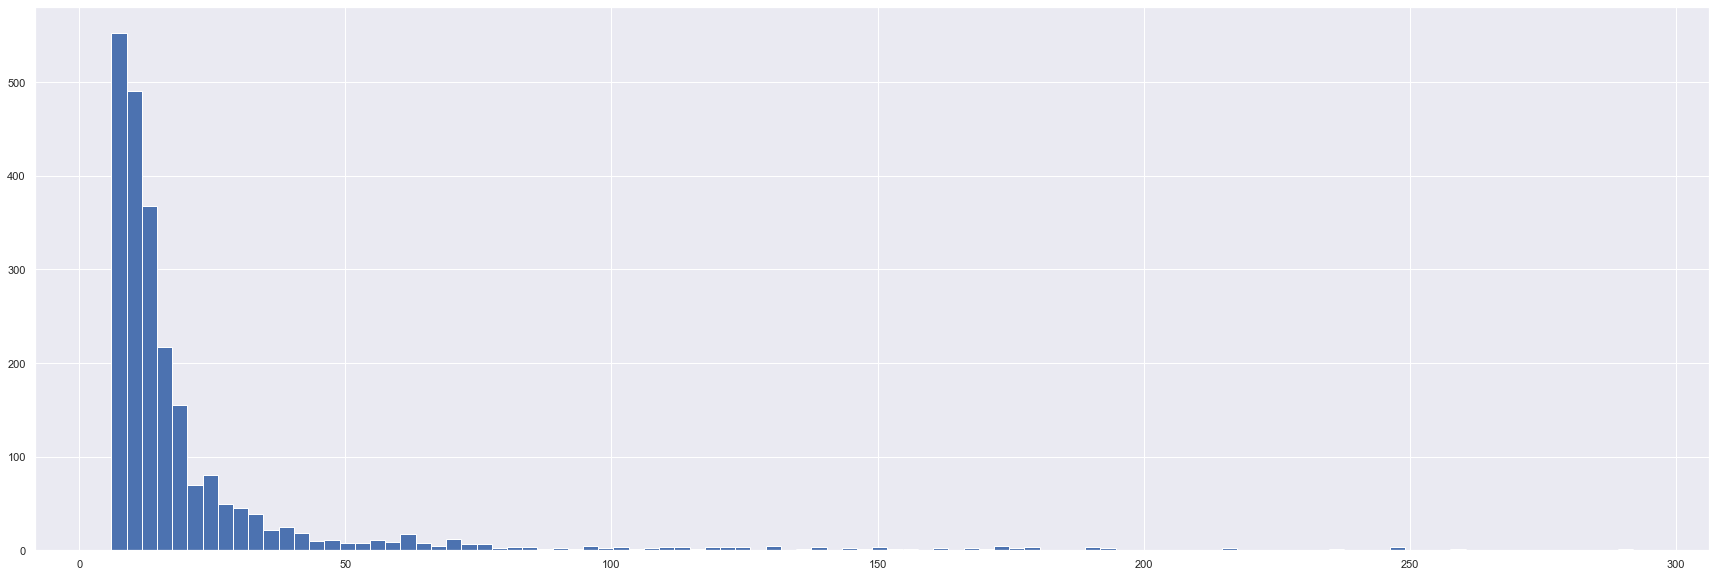

In [70]:
df["purchase_time_diff"].hist(bins=100)
plt.show()


In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)


In [73]:
def eval(y_real, y_pred):
    err = y_real - y_pred
    mae = abs(err).mean()
    mse = (err**2).mean().round(2)
    rmse = ((err**2).mean() ** (0.5)).round(2)
    return mae, rmse, mse


In [74]:
def train_eval_model(params, X, y):
    params["n_estimators"] = int(params["n_estimators"])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    xgb_model = xgb.XGBRegressor(
        seed=42, use_label_encoder=False, tree_method="gpu_hist", gpu_id=0, **params
    )
    xgb_model.fit(X_train, y_train, eval_metric="rmse")
    preds = xgb_model.predict(X_test)
    mae, rmse, mse = eval(y_test, preds)
    return xgb_model, mae, rmse, mse


In [75]:
xgb_model = xgb.XGBRegressor(
    seed=42,
    use_label_encoder=False,
    tree_method="gpu_hist",
    gpu_id=0,
)
xgb_model.fit(X_train, y_train, eval_metric="rmse")


C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=0, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=1, tree_method='gpu_hist', use_label_encoder=False,
             validate_parameters=1, verbosity=None)

In [76]:
preds = xgb_model.predict(X_test)
mae, rmse, mse = eval(y_test, preds)


In [77]:
mae


2.3499140943217482

In [78]:
rmse


7.69

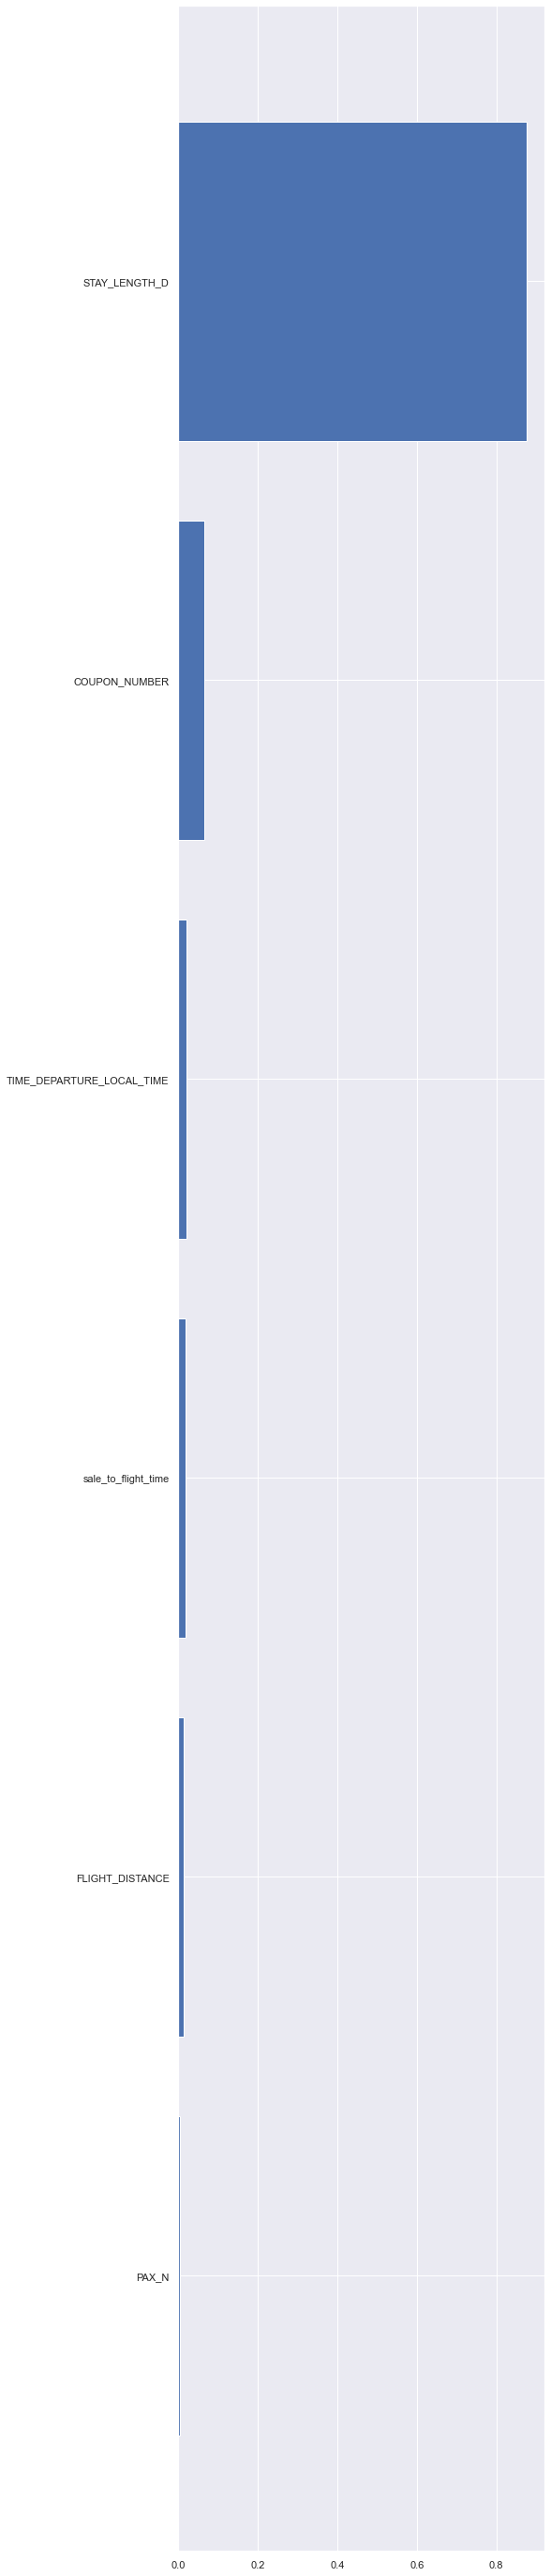

In [79]:
sorted_idx = xgb_model.feature_importances_.argsort()
plt.figure(figsize=(7, 50))
plt.barh(X_train.columns[sorted_idx], xgb_model.feature_importances_[sorted_idx])
plt.show()


In [80]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import xgboost as xgb
from sklearn.metrics import roc_auc_score


def score(params):
    print("Training with params: ")
    print(params)
    num_round = int(params["n_estimators"])
    del params["n_estimators"]
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)
    gbm_model = xgb.train(params, dtrain, num_round, verbose_eval=True)
    predictions = gbm_model.predict(dvalid, ntree_limit=gbm_model.best_iteration + 1)
    mae, rmse, mse = eval(y_test, predictions)
    print(f"MAE: {mae} - RMSE: {rmse} - MSE: {mse}")
    return {"loss": mae, "status": STATUS_OK}


def optimize(trials):

    space = {
        "n_estimators": hp.quniform("n_estimators", 10, 300, 1),
        "eta": hp.quniform("eta", 0.025, 0.5, 0.025),
        "max_depth": hp.choice("max_depth", np.arange(1, 16, dtype=int)),
        "min_child_weight": hp.quniform("min_child_weight", 1, 6, 1),
        "subsample": hp.quniform("subsample", 0.5, 1, 0.05),
        "gamma": hp.quniform("gamma", 0.5, 1, 0.05),
        "colsample_bytree": hp.quniform("colsample_bytree", 0.5, 1, 0.05),
        "objective": "reg:squarederror",
        "booster": "gbtree",
        "tree_method": "auto",
        "tree_method": "gpu_hist",
        "gpu_id": 0,
    }

    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=100)
    return best


In [81]:
trials = Trials()

best_hypers = optimize(trials)


Training with params:                                  
{'booster': 'gbtree', 'colsample_bytree': 0.8500000000000001, 'eta': 0.375, 'gamma': 0.5, 'gpu_id': 0, 'max_depth': 8, 'min_child_weight': 4.0, 'n_estimators': 100.0, 'objective': 'reg:squarederror', 'subsample': 0.8500000000000001, 'tree_method': 'gpu_hist'}
  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




MAE: 3.3586956639575143 - RMSE: 8.7 - MSE: 75.61       
Training with params:                                                            
{'booster': 'gbtree', 'colsample_bytree': 0.5, 'eta': 0.05, 'gamma': 0.7000000000000001, 'gpu_id': 0, 'max_depth': 8, 'min_child_weight': 2.0, 'n_estimators': 125.0, 'objective': 'reg:squarederror', 'subsample': 0.8500000000000001, 'tree_method': 'gpu_hist'}
  1%|          | 1/100 [00:01<01:53,  1.15s/trial, best loss: 3.3586956639575143]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.




MAE: 3.570297372646821 - RMSE: 8.26 - MSE: 68.22                                 
Training with params:                                                            
{'booster': 'gbtree', 'colsample_bytree': 0.5, 'eta': 0.5, 'gamma': 0.8500000000000001, 'gpu_id': 0, 'max_depth': 4, 'min_child_weight': 5.0, 'n_estimators': 71.0, 'objective': 'reg:squarederror', 'subsample': 0.6000000000000001, 'tree_method': 'gpu_hist'}
MAE: 3.418709654201809 - RMSE: 8.13 - MSE: 66.02                                 
Training with params:                                                            
{'booster': 'gbtree', 'colsample_bytree': 0.9, 'eta': 0.25, 'gamma': 0.55, 'gpu_id': 0, 'max_depth': 15, 'min_child_weight': 4.0, 'n_estimators': 157.0, 'objective': 'reg:squarederror', 'subsample': 0.6000000000000001, 'tree_method': 'gpu_hist'}
MAE: 2.8929314297488613 - RMSE: 8.08 - MSE: 65.36                                
Training with params:                                                            
{'boo

In [82]:
xgb_model, mae, rmse, mse = train_eval_model(best_hypers, X, Y)


In [83]:
print(mae)


2.2186725547171045


In [84]:
print(rmse)
print(rmse_2)


5.82
6.54


In [85]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, KFold
import xgboost as xgb

xgb_model = xgb.XGBRegressor(
    **best_hypers,
    seed=42,
    use_label_encoder=False,
    tree_method="gpu_hist",
    gpu_id=0,
)
kfold = KFold(n_splits=5)
results = cross_val_score(
    xgb_model,
    X["STAY_LENGTH_D"],
    Y,
    cv=kfold,
    scoring="neg_mean_absolute_error",
    fit_params={"eval_metric": "mae"},
)
print("średnia:", results.mean())
print("mae:", results)

prev_result = results.mean()


col_list = ["STAY_LENGTH_D"]
all_cols = X.columns.tolist()

x = 0

while x < len(all_cols):
    if len(results) != 1 and results.mean() > prev_result:
        prev_result = results.mean()
    while all_cols[x] in col_list:
        x += 1
    else:
        col_list.append(all_cols[x])
    kolumny = X[col_list]
    xgb_model = xgb.XGBRegressor(
        **best_hypers,
        seed=42,
        use_label_encoder=False,
        tree_method="gpu_hist",
        gpu_id=0,
    )
    kfold = KFold(n_splits=5)
    results = cross_val_score(
        xgb_model,
        kolumny,
        Y,
        cv=kfold,
        scoring="neg_mean_absolute_error",
        fit_params={"eval_metric": "mae"},
    )
    print("średnia:", results.mean())
    print("mae:", results)
    print("kolumny:", kolumny.columns)
    if prev_result > results.mean():
        col_list.remove(all_cols[x])
    x += 1


średnia: -3.1087306331502984
mae: [-2.84908903 -3.46725517 -3.47810787 -3.35612977 -2.39307133]


C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



KeyboardInterrupt: 

In [ ]:
col_list


['STAY_LENGTH_D',
 'COUPON_NUMBER',
 'TIME_DEPARTURE_LOCAL_TIME',
 'FLIGHT_DISTANCE',
 'BOOKING_DOMESTIC_FLAG',
 'PAX_N',
 'sale_to_flight_time']

In [86]:
xgb_model_2, mae_2, rmse_2, mse_2 = train_eval_model(best_hypers, X[selected_cols], Y)


C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



In [87]:
mae_2


1.8738708985157502

In [98]:
rmse_2

5.27

In [99]:
mse

33.9

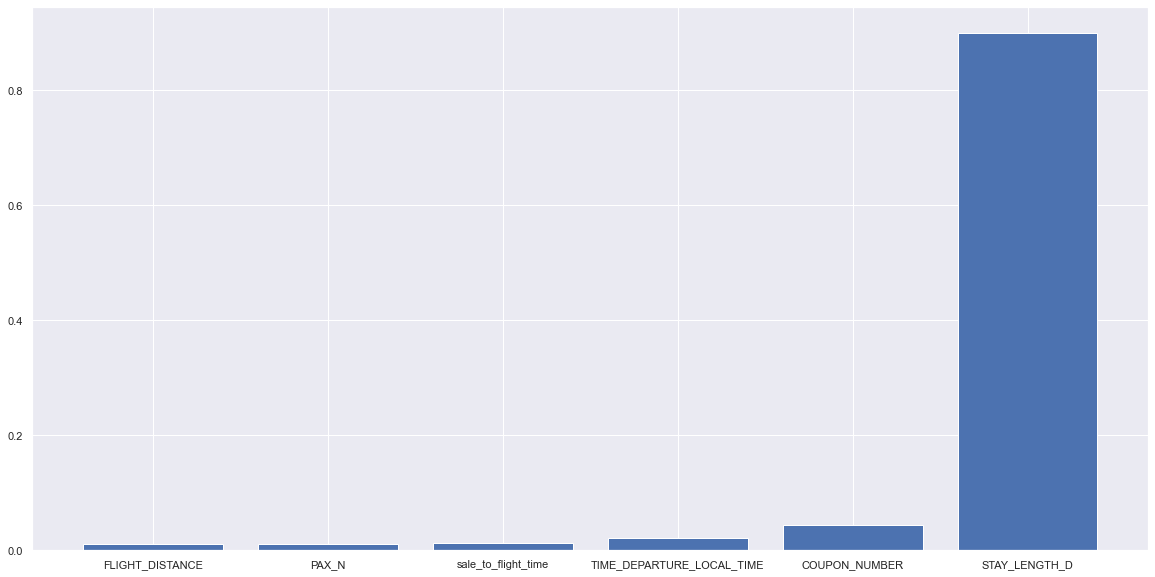

In [100]:
sorted_idx = xgb_model_2.feature_importances_.argsort()
plt.figure(figsize=(20, 10))
plt.bar(
    X_train[selected_cols].columns[sorted_idx],
    xgb_model_2.feature_importances_[sorted_idx],
)
plt.show()

In [88]:
import dalex as dx

example = X_test[selected_cols].iloc[42]
xgb_exp = dx.Explainer(xgb_model_2, X[selected_cols], Y, label="XGB Pipeline")


Preparation of a new explainer is initiated

  -> data              : 2336 rows 6 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 2336 values
  -> model_class       : xgboost.sklearn.XGBRegressor (default)
  -> label             : XGB Pipeline
  -> predict function  : <function yhat_default at 0x000001DC6AA28E50> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 5.54, mean = 21.2, max = 2.9e+02
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -59.3, mean = -0.062, max = 54.6
  -> model_info        : package xgboost

A new explainer has been created!


C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



In [89]:
bd_example = xgb_exp.predict_parts(example, type="break_down")
bd_example.result


,variable_name,variable_value,variable,cumulative,contribution,sign,position,label
0,intercept,1,intercept,21.234077,21.234077,1.0,7,XGB Pipeline
1,COUPON_NUMBER,2.0,COUPON_NUMBER = 2.0,21.566523,0.332445,1.0,6,XGB Pipeline
2,TIME_DEPARTURE_LOCAL_TIME,13.0,TIME_DEPARTURE_LOCAL_TIME = 13.0,21.933622,0.367100,1.0,5,XGB Pipeline
3,FLIGHT_DISTANCE,7521.0,FLIGHT_DISTANCE = 7521.0,22.089903,0.156281,1.0,4,XGB Pipeline
4,sale_to_flight_time,81.0,sale_to_flight_time = 81.0,21.634933,-0.454969,-1.0,3,XGB Pipeline
5,PAX_N,3.0,PAX_N = 3.0,21.474939,-0.159994,-1.0,2,XGB Pipeline
6,STAY_LENGTH_D,20.0,STAY_LENGTH_D = 20.0,18.476612,-2.998327,-1.0,1,XGB Pipeline
7,,,prediction,18.476614,18.476614,1.0,0,XGB Pipeline


In [90]:
import plotly.io as pio

pio.renderers.default = "notebook_connected"


In [92]:
bd_example.plot(max_vars=30)
print("Prawdziwy wynik:", y_test.iloc[69])


Prawdziwy wynik: 9.0


In [94]:
cp_example = xgb_exp.predict_profile(example)
cp_example.result


Calculating ceteris paribus:   0%|          | 0/6 [00:00<?, ?it/s]C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

C:\Gan

,STAY_LENGTH_D,COUPON_NUMBER,TIME_DEPARTURE_LOCAL_TIME,FLIGHT_DISTANCE,PAX_N,sale_to_flight_time,_original_,_yhat_,_vname_,_ids_,_label_
6120,1.00,2.0,13.0,7521.0,3.0,81.00,20.0,12.022713,STAY_LENGTH_D,6120,XGB Pipeline
6120,3.51,2.0,13.0,7521.0,3.0,81.00,20.0,14.777787,STAY_LENGTH_D,6120,XGB Pipeline
6120,6.02,2.0,13.0,7521.0,3.0,81.00,20.0,8.447774,STAY_LENGTH_D,6120,XGB Pipeline
6120,8.53,2.0,13.0,7521.0,3.0,81.00,20.0,6.650076,STAY_LENGTH_D,6120,XGB Pipeline
6120,11.04,2.0,13.0,7521.0,3.0,81.00,20.0,8.791143,STAY_LENGTH_D,6120,XGB Pipeline
...,...,...,...,...,...,...,...,...,...,...,...
6120,20.00,2.0,13.0,7521.0,3.0,340.84,81.0,18.053436,sale_to_flight_time,6120,XGB Pipeline
6120,20.00,2.0,13.0,7521.0,3.0,344.38,81.0,18.053436,sale_to_flight_time,6120,XGB Pipeline
6120,20.00,2.0,13.0,7521.0,3.0,347.92,81.0,18.053436,sale_to_flight_time,6120,XGB Pipeline
6120,20.00,2.0,13.0,7521.0,3.0,351.46,81.0,18.053436,sale_to_flight_time,6120,XGB Pipeline


In [101]:
cp_example.plot(variables=selected_cols)


In [102]:
cp_example.plot(variables=['COUPON_NUMBER'])


In [96]:
sh_example = xgb_exp.predict_parts(example, type="shap")
sh_example.result


C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:

,variable,contribution,variable_name,variable_value,sign,label,B
0,COUPON_NUMBER = 2.0,0.332445,COUPON_NUMBER,2.0,1.0,XGB Pipeline,1
1,FLIGHT_DISTANCE = 7521.0,0.150341,FLIGHT_DISTANCE,7521.0,1.0,XGB Pipeline,1
2,TIME_DEPARTURE_LOCAL_TIME = 13.0,0.373039,TIME_DEPARTURE_LOCAL_TIME,13.0,1.0,XGB Pipeline,1
3,sale_to_flight_time = 81.0,-0.454969,sale_to_flight_time,81.0,-1.0,XGB Pipeline,1
4,STAY_LENGTH_D = 20.0,-3.739389,STAY_LENGTH_D,20.0,-1.0,XGB Pipeline,1
...,...,...,...,...,...,...,...
1,TIME_DEPARTURE_LOCAL_TIME = 13.0,0.605276,TIME_DEPARTURE_LOCAL_TIME,13.0,1.0,XGB Pipeline,0
2,sale_to_flight_time = 81.0,-0.273920,sale_to_flight_time,81.0,-1.0,XGB Pipeline,0
3,COUPON_NUMBER = 2.0,0.205075,COUPON_NUMBER,2.0,1.0,XGB Pipeline,0
4,FLIGHT_DISTANCE = 7521.0,0.138135,FLIGHT_DISTANCE,7521.0,1.0,XGB Pipeline,0


In [ ]:
sh_example.plot(max_vars=30)


In [ ]:
X


,STAY_LENGTH_D,COUPON_NUMBER,TIME_DEPARTURE_LOCAL_TIME,FLIGHT_DISTANCE,BOOKING_DOMESTIC_FLAG,PAX_N,sale_to_flight_time
4,26.0,2,17,6873,0,1,29
6,152.0,4,17,6942,0,1,277
9,25.0,2,17,6873,0,1,57
11,61.0,4,16,6863,0,2,231
13,30.0,3,10,8598,0,2,205
...,...,...,...,...,...,...,...
8786,8.0,2,17,6942,0,2,31
8789,69.0,2,16,7521,0,2,186
8792,14.0,2,0,9410,0,1,52
8794,11.0,2,16,6863,0,1,10
